In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_22.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,22,0.253,2.23,-20
1,22,0.252,2.23,-20
2,22,0.253,2.23,-20
3,22,0.253,2.23,-20
4,22,0.252,2.23,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


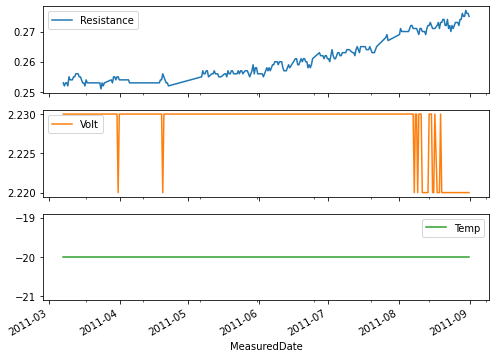

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

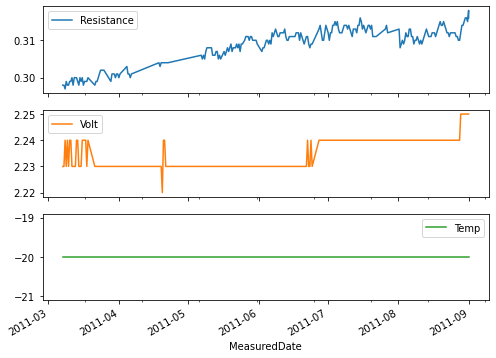

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,251.0,22.000000,0.000000,22.000,22.000,22.00,22.000,22.000
Resistance,251.0,0.261355,0.006944,0.251,0.256,0.26,0.266,0.277
Volt,251.0,2.228406,0.003667,2.220,2.230,2.23,2.230,2.230
Temp,251.0,-20.000000,0.000000,-20.000,-20.000,-20.00,-20.000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.076923,1.0,0.0
1,0.038462,1.0,0.0
2,0.076923,1.0,0.0
3,0.076923,1.0,0.0
4,0.038462,1.0,0.0


<AxesSubplot:>

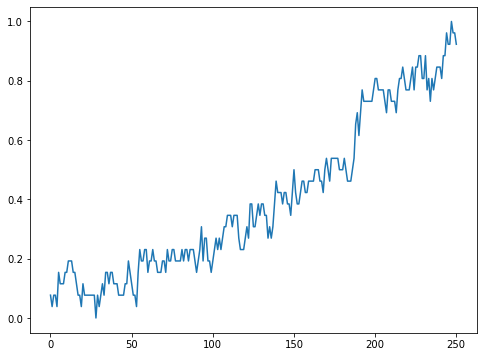

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

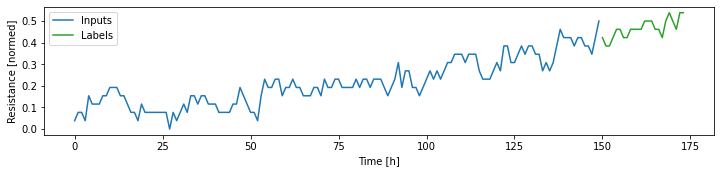

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 0.4057 - mean_absolute_error: 0.4880
Epoch 2/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.4015 - mean_absolute_error: 0.4851
Epoch 3/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.3969 - mean_absolute_error: 0.4820
Epoch 4/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.3919 - mean_absolute_error: 0.4785
Epoch 5/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.3862 - mean_absolute_error: 0.4745
Epoch 6/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.3799 - mean_absolute_error: 0.4701
Epoch 7/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.3728 - mean_absolute_error: 0.4650
Epoch 8/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.3647 - mean_absolute_error: 0.4592
Epoch 9/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.3555 - mean_absolute_error: 0.4525
Epoch 10/1

Epoch 34/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0230 - mean_absolute_error: 0.1207
Epoch 35/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0187 - mean_absolute_error: 0.1102
Epoch 36/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0150 - mean_absolute_error: 0.0992
Epoch 37/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0117 - mean_absolute_error: 0.0876
Epoch 38/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0089 - mean_absolute_error: 0.0757
Epoch 39/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0065 - mean_absolute_error: 0.0636
Epoch 40/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0047 - mean_absolute_error: 0.0515
Epoch 41/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0032 - mean_absolute_error: 0.0395
Epoch 42/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0022 - mean_absolute_error: 0.

Epoch 67/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.0629e-04 - mean_absolute_error: 0.0127
Epoch 68/1500
1/1 [==============================] - 0s 89ms/step - loss: 2.2004e-04 - mean_absolute_error: 0.0100
Epoch 69/1500
1/1 [==============================] - 0s 91ms/step - loss: 1.7384e-04 - mean_absolute_error: 0.0080
Epoch 70/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.5993e-04 - mean_absolute_error: 0.0063
Epoch 71/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.7024e-04 - mean_absolute_error: 0.0071
Epoch 72/1500
1/1 [==============================] - 0s 92ms/step - loss: 1.9694e-04 - mean_absolute_error: 0.0088
Epoch 73/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.3296e-04 - mean_absolute_error: 0.0102
Epoch 74/1500
1/1 [==============================] - 0s 92ms/step - loss: 2.7223e-04 - mean_absolute_error: 0.0114
Epoch 75/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.0987

1/1 [==============================] - 0s 105ms/step - loss: 1.2880e-04 - mean_absolute_error: 0.0064
Epoch 100/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.3147e-04 - mean_absolute_error: 0.0067
Epoch 101/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.3405e-04 - mean_absolute_error: 0.0070
Epoch 102/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.3625e-04 - mean_absolute_error: 0.0071
Epoch 103/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.3786e-04 - mean_absolute_error: 0.0073
Epoch 104/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.3876e-04 - mean_absolute_error: 0.0073
Epoch 105/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.3891e-04 - mean_absolute_error: 0.0073
Epoch 106/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.3833e-04 - mean_absolute_error: 0.0072
Epoch 107/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.3710e-

1/1 [==============================] - 0s 101ms/step - loss: 1.1978e-04 - mean_absolute_error: 0.0053
Epoch 132/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1954e-04 - mean_absolute_error: 0.0053
Epoch 133/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1929e-04 - mean_absolute_error: 0.0052
Epoch 134/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1906e-04 - mean_absolute_error: 0.0051
Epoch 135/1500
1/1 [==============================] - 0s 108ms/step - loss: 1.1884e-04 - mean_absolute_error: 0.0050
Epoch 136/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1865e-04 - mean_absolute_error: 0.0050
Epoch 137/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1851e-04 - mean_absolute_error: 0.0049
Epoch 138/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1839e-04 - mean_absolute_error: 0.0049
Epoch 139/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.183

1/1 [==============================] - 0s 95ms/step - loss: 1.1822e-04 - mean_absolute_error: 0.0049
Epoch 164/1500
1/1 [==============================] - 0s 92ms/step - loss: 1.1822e-04 - mean_absolute_error: 0.0049
Epoch 165/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1822e-04 - mean_absolute_error: 0.0049
Epoch 166/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1822e-04 - mean_absolute_error: 0.0049
Epoch 167/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1823e-04 - mean_absolute_error: 0.0049
Epoch 168/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1823e-04 - mean_absolute_error: 0.0049
Epoch 169/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1823e-04 - mean_absolute_error: 0.0049
Epoch 170/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1823e-04 - mean_absolute_error: 0.0049
Epoch 171/1500
1/1 [==============================] - 0s 92ms/step - loss: 1.1823e-04 -

1/1 [==============================] - 0s 93ms/step - loss: 1.1821e-04 - mean_absolute_error: 0.0049
Epoch 196/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1821e-04 - mean_absolute_error: 0.0049
Epoch 197/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1821e-04 - mean_absolute_error: 0.0049
Epoch 198/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1821e-04 - mean_absolute_error: 0.0049
Epoch 199/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1821e-04 - mean_absolute_error: 0.0049
Epoch 200/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1821e-04 - mean_absolute_error: 0.0049
Epoch 201/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 202/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 203/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1820e-0

1/1 [==============================] - 0s 101ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 228/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 229/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 230/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 231/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 232/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 233/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 234/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1820e-04 - mean_absolute_error: 0.0049
Epoch 235/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1820e

1/1 [==============================] - 0s 95ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 260/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 261/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 262/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 263/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 264/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 265/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 266/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 267/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1819e-0

1/1 [==============================] - 0s 101ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 292/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 293/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 294/1500
1/1 [==============================] - 0s 92ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 295/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 296/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 297/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 298/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1819e-04 - mean_absolute_error: 0.0049
Epoch 299/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1819e

1/1 [==============================] - 0s 100ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 324/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 325/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 326/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 327/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 328/1500
1/1 [==============================] - 0s 109ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 329/1500
1/1 [==============================] - 0s 117ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 330/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 331/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.18

1/1 [==============================] - 0s 103ms/step - loss: 1.1818e-04 - mean_absolute_error: 0.0049
Epoch 356/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 357/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 358/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 359/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 360/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 361/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 362/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 363/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1817e

1/1 [==============================] - 0s 105ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 388/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 389/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 390/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 391/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 392/1500
1/1 [==============================] - 0s 117ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 393/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 394/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1817e-04 - mean_absolute_error: 0.0049
Epoch 395/1500
1/1 [==============================] - 0s 89ms/step - loss: 1.1817e-

1/1 [==============================] - 0s 105ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 420/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 421/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 422/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 423/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 424/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 425/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 426/1500
1/1 [==============================] - 0s 115ms/step - loss: 1.1816e-04 - mean_absolute_error: 0.0049
Epoch 427/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.18

1/1 [==============================] - 0s 96ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 452/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 453/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 454/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 455/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 456/1500
1/1 [==============================] - 0s 108ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 457/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 458/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1815e-04 - mean_absolute_error: 0.0049
Epoch 459/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1815e-0

1/1 [==============================] - 0s 105ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 484/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 485/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 486/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 487/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 488/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 489/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 490/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 491/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1814

1/1 [==============================] - 0s 102ms/step - loss: 1.1814e-04 - mean_absolute_error: 0.0049
Epoch 516/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 517/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 518/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 519/1500
1/1 [==============================] - 0s 116ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 520/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 521/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 522/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 523/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1813e-

1/1 [==============================] - 0s 98ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 548/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 549/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 550/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1813e-04 - mean_absolute_error: 0.0049
Epoch 551/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 552/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 553/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 554/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 555/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1812e-

1/1 [==============================] - 0s 102ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 580/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 581/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 582/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 583/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 584/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1812e-04 - mean_absolute_error: 0.0049
Epoch 585/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 586/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 587/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.18

1/1 [==============================] - 0s 93ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 612/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 613/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 614/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 615/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 616/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 617/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1811e-04 - mean_absolute_error: 0.0049
Epoch 618/1500
1/1 [==============================] - 0s 92ms/step - loss: 1.1810e-04 - mean_absolute_error: 0.0049
Epoch 619/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1810e-04 -

1/1 [==============================] - 0s 94ms/step - loss: 1.1810e-04 - mean_absolute_error: 0.0049
Epoch 644/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1810e-04 - mean_absolute_error: 0.0049
Epoch 645/1500
1/1 [==============================] - 0s 92ms/step - loss: 1.1810e-04 - mean_absolute_error: 0.0049
Epoch 646/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1810e-04 - mean_absolute_error: 0.0049
Epoch 647/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1810e-04 - mean_absolute_error: 0.0049
Epoch 648/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1810e-04 - mean_absolute_error: 0.0049
Epoch 649/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1809e-04 - mean_absolute_error: 0.0049
Epoch 650/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1809e-04 - mean_absolute_error: 0.0049
Epoch 651/1500
1/1 [==============================] - 0s 163ms/step - loss: 1.1809e-0

1/1 [==============================] - 0s 121ms/step - loss: 1.1809e-04 - mean_absolute_error: 0.0049
Epoch 676/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1809e-04 - mean_absolute_error: 0.0049
Epoch 677/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1809e-04 - mean_absolute_error: 0.0049
Epoch 678/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1809e-04 - mean_absolute_error: 0.0049
Epoch 679/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1808e-04 - mean_absolute_error: 0.0049
Epoch 680/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1808e-04 - mean_absolute_error: 0.0049
Epoch 681/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1808e-04 - mean_absolute_error: 0.0049
Epoch 682/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1808e-04 - mean_absolute_error: 0.0049
Epoch 683/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1808

1/1 [==============================] - 0s 101ms/step - loss: 1.1808e-04 - mean_absolute_error: 0.0049
Epoch 708/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1808e-04 - mean_absolute_error: 0.0049
Epoch 709/1500
1/1 [==============================] - 0s 109ms/step - loss: 1.1807e-04 - mean_absolute_error: 0.0049
Epoch 710/1500
1/1 [==============================] - 0s 119ms/step - loss: 1.1807e-04 - mean_absolute_error: 0.0049
Epoch 711/1500
1/1 [==============================] - 0s 116ms/step - loss: 1.1807e-04 - mean_absolute_error: 0.0049
Epoch 712/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1807e-04 - mean_absolute_error: 0.0049
Epoch 713/1500
1/1 [==============================] - 0s 151ms/step - loss: 1.1807e-04 - mean_absolute_error: 0.0049
Epoch 714/1500
1/1 [==============================] - 0s 202ms/step - loss: 1.1807e-04 - mean_absolute_error: 0.0049
Epoch 715/1500
1/1 [==============================] - 0s 126ms/step - loss: 1.18

1/1 [==============================] - 0s 99ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 740/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 741/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 742/1500
1/1 [==============================] - 0s 116ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 743/1500
1/1 [==============================] - 0s 120ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 744/1500
1/1 [==============================] - 0s 116ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 745/1500
1/1 [==============================] - 0s 112ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 746/1500
1/1 [==============================] - 0s 109ms/step - loss: 1.1806e-04 - mean_absolute_error: 0.0049
Epoch 747/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.18

Epoch 771/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 772/1500
1/1 [==============================] - 0s 109ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 773/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 774/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 775/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 776/1500
1/1 [==============================] - 0s 109ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 777/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 778/1500
1/1 [==============================] - 0s 121ms/step - loss: 1.1805e-04 - mean_absolute_error: 0.0049
Epoch 779/1500
1/1 [==============================] - 0s 112ms/st

1/1 [==============================] - 0s 93ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 804/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 805/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 806/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 807/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 808/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 809/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 810/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1804e-04 - mean_absolute_error: 0.0049
Epoch 811/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1804e-04 

1/1 [==============================] - 0s 108ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 836/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 837/1500
1/1 [==============================] - 0s 110ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 838/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 839/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 840/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 841/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 842/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1803e-04 - mean_absolute_error: 0.0049
Epoch 843/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1803

1/1 [==============================] - 0s 107ms/step - loss: 1.1802e-04 - mean_absolute_error: 0.0049
Epoch 868/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1802e-04 - mean_absolute_error: 0.0049
Epoch 869/1500
1/1 [==============================] - 0s 113ms/step - loss: 1.1802e-04 - mean_absolute_error: 0.0049
Epoch 870/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1801e-04 - mean_absolute_error: 0.0049
Epoch 871/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1801e-04 - mean_absolute_error: 0.0049
Epoch 872/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1801e-04 - mean_absolute_error: 0.0049
Epoch 873/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1801e-04 - mean_absolute_error: 0.0049
Epoch 874/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1801e-04 - mean_absolute_error: 0.0049
Epoch 875/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1801

1/1 [==============================] - 0s 103ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 900/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 901/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 902/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 903/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 904/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 905/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 906/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1800e-04 - mean_absolute_error: 0.0049
Epoch 907/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1800e

1/1 [==============================] - 0s 92ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 932/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 933/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 934/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 935/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 936/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 937/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 938/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1799e-04 - mean_absolute_error: 0.0049
Epoch 939/1500
1/1 [==============================] - 0s 116ms/step - loss: 1.1799e-

1/1 [==============================] - 0s 105ms/step - loss: 1.1798e-04 - mean_absolute_error: 0.0049
Epoch 964/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1798e-04 - mean_absolute_error: 0.0049
Epoch 965/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1798e-04 - mean_absolute_error: 0.0049
Epoch 966/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1797e-04 - mean_absolute_error: 0.0049
Epoch 967/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1797e-04 - mean_absolute_error: 0.0049
Epoch 968/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1797e-04 - mean_absolute_error: 0.0049
Epoch 969/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1797e-04 - mean_absolute_error: 0.0049
Epoch 970/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1797e-04 - mean_absolute_error: 0.0049
Epoch 971/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1797e

1/1 [==============================] - 0s 106ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 996/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 997/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 998/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 999/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 1000/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 1001/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 1002/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1796e-04 - mean_absolute_error: 0.0049
Epoch 1003/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1796

Epoch 1027/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1795e-04 - mean_absolute_error: 0.0049
Epoch 1028/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.1795e-04 - mean_absolute_error: 0.0049
Epoch 1029/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1795e-04 - mean_absolute_error: 0.0049
Epoch 1030/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1795e-04 - mean_absolute_error: 0.0049
Epoch 1031/1500
1/1 [==============================] - 0s 113ms/step - loss: 1.1795e-04 - mean_absolute_error: 0.0049
Epoch 1032/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1795e-04 - mean_absolute_error: 0.0049
Epoch 1033/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1794e-04 - mean_absolute_error: 0.0049
Epoch 1034/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.1794e-04 - mean_absolute_error: 0.0049
Epoch 1035/1500
1/1 [==============================] - 0s 

Epoch 1059/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1060/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1061/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1062/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1063/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1064/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1065/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1066/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1793e-04 - mean_absolute_error: 0.0049
Epoch 1067/1500
1/1 [==============================] - 0s 98m

Epoch 1091/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1792e-04 - mean_absolute_error: 0.0049
Epoch 1092/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1792e-04 - mean_absolute_error: 0.0049
Epoch 1093/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1792e-04 - mean_absolute_error: 0.0049
Epoch 1094/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1792e-04 - mean_absolute_error: 0.0049
Epoch 1095/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1792e-04 - mean_absolute_error: 0.0049
Epoch 1096/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1792e-04 - mean_absolute_error: 0.0049
Epoch 1097/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1791e-04 - mean_absolute_error: 0.0049
Epoch 1098/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1791e-04 - mean_absolute_error: 0.0049
Epoch 1099/1500
1/1 [==============================] - 0s 110m

Epoch 1123/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1124/1500
1/1 [==============================] - 0s 110ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1125/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1126/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1127/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1128/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1129/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1130/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1790e-04 - mean_absolute_error: 0.0049
Epoch 1131/1500
1/1 [==============================] - 0

Epoch 1155/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1789e-04 - mean_absolute_error: 0.0049
Epoch 1156/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1789e-04 - mean_absolute_error: 0.0049
Epoch 1157/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1788e-04 - mean_absolute_error: 0.0049
Epoch 1158/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1788e-04 - mean_absolute_error: 0.0049
Epoch 1159/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1788e-04 - mean_absolute_error: 0.0049
Epoch 1160/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1788e-04 - mean_absolute_error: 0.0049
Epoch 1161/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1788e-04 - mean_absolute_error: 0.0049
Epoch 1162/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1788e-04 - mean_absolute_error: 0.0049
Epoch 1163/1500
1/1 [==============================] - 0s 96ms

Epoch 1187/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1188/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1189/1500
1/1 [==============================] - 0s 117ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1190/1500
1/1 [==============================] - 0s 117ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1191/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1192/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1193/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1194/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1787e-04 - mean_absolute_error: 0.0049
Epoch 1195/1500
1/1 [==============================] - 0s

Epoch 1219/1500
1/1 [==============================] - 0s 108ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1220/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1221/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1222/1500
1/1 [==============================] - 0s 111ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1223/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1224/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1225/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1226/1500
1/1 [==============================] - 0s 93ms/step - loss: 1.1785e-04 - mean_absolute_error: 0.0049
Epoch 1227/1500
1/1 [==============================] - 0s 9

Epoch 1251/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1784e-04 - mean_absolute_error: 0.0049
Epoch 1252/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1784e-04 - mean_absolute_error: 0.0049
Epoch 1253/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1783e-04 - mean_absolute_error: 0.0049
Epoch 1254/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1783e-04 - mean_absolute_error: 0.0049
Epoch 1255/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1783e-04 - mean_absolute_error: 0.0049
Epoch 1256/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1783e-04 - mean_absolute_error: 0.0049
Epoch 1257/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1783e-04 - mean_absolute_error: 0.0049
Epoch 1258/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1783e-04 - mean_absolute_error: 0.0049
Epoch 1259/1500
1/1 [==============================] - 0s 97ms/s

Epoch 1283/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1782e-04 - mean_absolute_error: 0.0049
Epoch 1284/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1782e-04 - mean_absolute_error: 0.0049
Epoch 1285/1500
1/1 [==============================] - 0s 110ms/step - loss: 1.1782e-04 - mean_absolute_error: 0.0049
Epoch 1286/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1782e-04 - mean_absolute_error: 0.0049
Epoch 1287/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1782e-04 - mean_absolute_error: 0.0049
Epoch 1288/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1782e-04 - mean_absolute_error: 0.0049
Epoch 1289/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1781e-04 - mean_absolute_error: 0.0049
Epoch 1290/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1781e-04 - mean_absolute_error: 0.0049
Epoch 1291/1500
1/1 [==============================] - 0

Epoch 1315/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1316/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1317/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1318/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1319/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1320/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1321/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1322/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0049
Epoch 1323/1500
1/1 [==============================] - 0s 96

Epoch 1347/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1348/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1349/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1350/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1351/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1352/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1353/1500
1/1 [==============================] - 0s 112ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1354/1500
1/1 [==============================] - 0s 116ms/step - loss: 1.1778e-04 - mean_absolute_error: 0.0049
Epoch 1355/1500
1/1 [==============================] - 0s 10

Epoch 1379/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1380/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1381/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1382/1500
1/1 [==============================] - 0s 107ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1383/1500
1/1 [==============================] - 0s 114ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1384/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1385/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1386/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1776e-04 - mean_absolute_error: 0.0049
Epoch 1387/1500
1/1 [==============================] - 0

Epoch 1411/1500
1/1 [==============================] - 0s 115ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1412/1500
1/1 [==============================] - 0s 123ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1413/1500
1/1 [==============================] - 0s 119ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1414/1500
1/1 [==============================] - 0s 108ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1415/1500
1/1 [==============================] - 0s 119ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1416/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1417/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1418/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1774e-04 - mean_absolute_error: 0.0049
Epoch 1419/1500
1/1 [==============================] - 0s 

Epoch 1443/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1444/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1445/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1446/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1447/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1448/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1449/1500
1/1 [==============================] - 0s 95ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1450/1500
1/1 [==============================] - 0s 94ms/step - loss: 1.1772e-04 - mean_absolute_error: 0.0049
Epoch 1451/1500
1/1 [==============================] - 0s 94ms

Epoch 1475/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1476/1500
1/1 [==============================] - 0s 98ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1477/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1478/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1479/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1480/1500
1/1 [==============================] - 0s 110ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1481/1500
1/1 [==============================] - 0s 104ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1482/1500
1/1 [==============================] - 0s 113ms/step - loss: 1.1770e-04 - mean_absolute_error: 0.0049
Epoch 1483/1500
1/1 [==============================] - 0s 

In [23]:
#pred = model.predict(test_df)

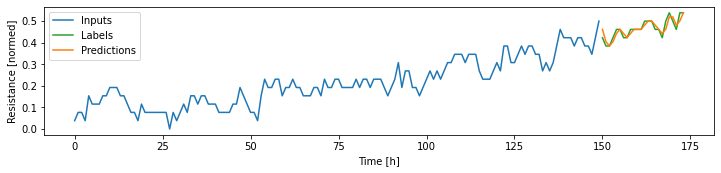

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)